Все импорты

In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.model_selection import iterative_train_test_split

import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from gensim.models import KeyedVectors

from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup


## 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы. (0.5 балла).

1.1 распакуем данные 

In [9]:
fname = "./test.zip"
path = "./"

with zipfile.ZipFile(fname, "r") as zf:
    for entry in tqdm(zf.infolist(), desc="Extracting"):
        try:
            zf.extract(entry, path)
        except zipfile.error as e:
            pass

Extracting: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


In [2]:
data_test = pd.read_csv('test.csv')

In [6]:
data_test

,id,text
0,29568,"ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн..."
1,29569,Пруды Москвы
2,29570,🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...
3,29571,24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...
4,29572,19-20 августа\nДетский клуб в кафе «Отдых»\nТе...
...,...,...
7387,36955,Концерт «Stabat Mater»\n24 и 25 марта в 20:00\...
7388,36956,СПЕКТАКЛЬ «ОДНАЖДЫ…»\nСпектакль для 1 зрителя....
7389,36957,вт.-пт. 10:00-20:00 можно бесплатно полетать н...
7390,36958,"ТЕАТРАЛЬНЫЙ СЕЗОН ""НА ВОДАХ""\nс 1 по 9 апреля ..."


In [4]:
fname = "./train.zip"
path = "./"

with zipfile.ZipFile(fname, "r") as zf:
    for entry in tqdm(zf.infolist(), desc="Extracting"):
        try:
            zf.extract(entry, path)
        except zipfile.error as e:
            pass

Extracting: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


In [22]:
data_train = pd.read_csv('train.csv')

In [23]:
data_train

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


1.2 визуализация
сейчас классы записаны в одну строчку, нужно разбить на разные столбцы это и суммы получить. так узнаем объем классов.

In [25]:
df = data_train['labels'].iloc[1] 
df

'0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1'

In [26]:
df = data_train

In [27]:
df

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


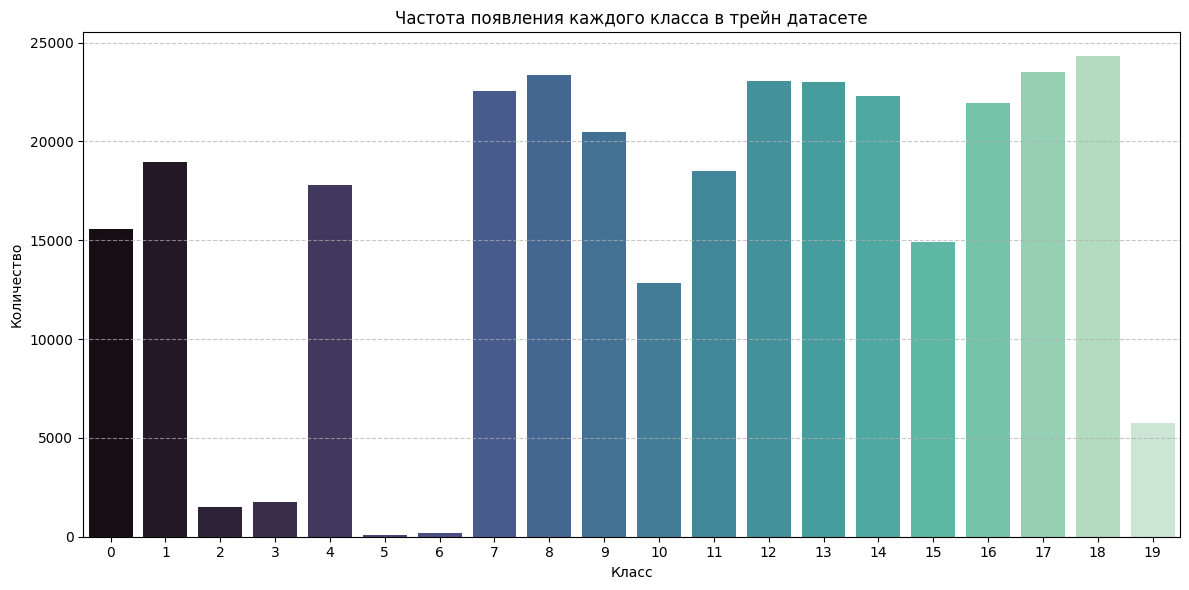

In [28]:
df['label_vector'] = df['labels'].apply(lambda x: [int(i) for i in x.split()])

label_array = np.stack(df['label_vector'].values)

class_frequencies = pd.Series(label_array.sum(axis=0), name='Количество примеров')
class_frequencies.index.name = 'ID класса'

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x=class_frequencies.index, y=class_frequencies.values, palette='mako')
plt.title('Частота появления каждого класса в трейн датасете')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

видим, что классы 2,3, 5, 6 практически не представлены в датасете. Дисбаланс классов, можно использовать взвешенные лоси,Undersampling/Oversampling (?) + нужно на трейн и тест делить взвешенно-аккуратно.

### Посчитаем, сколько меток у каждого примера


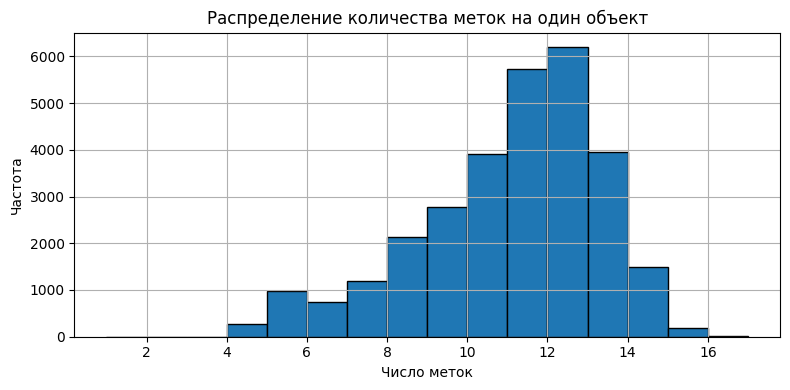

In [27]:
df['num_labels'] = df['label_vector'].apply(lambda x: sum(x))

plt.figure(figsize=(8, 4))
plt.hist(df['num_labels'], bins=range(1, df['num_labels'].max() + 2), edgecolor='black')
plt.title('Распределение количества меток на один объект')
plt.xlabel('Число меток')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()


 видим что часто на одном примере у нас 10-14 меток. в целом распределение похоже на нормальное, но смещено влево, в сторону примеров с большим кол-вом меток

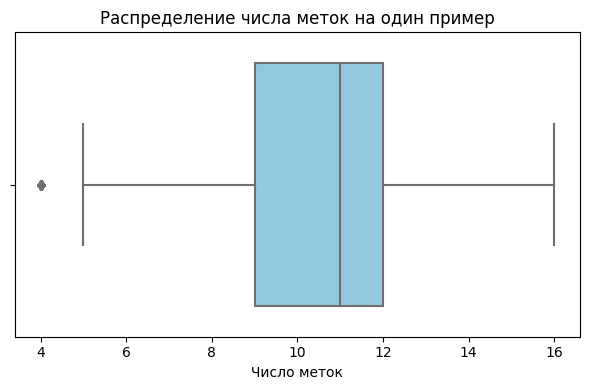

In [19]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['num_labels'], color='skyblue')
plt.title('Распределение числа меток на один пример')
plt.xlabel('Число меток')
plt.tight_layout()
plt.show()

In [20]:
data_train = pd.read_csv('train.csv')

In [21]:
data_train

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


тексты с мусором в виде смайликов, ссылок, хештегов. Также видно, что всё это - афиши каких-то мероприятий, причем публиковались , вероятно в вк или похожей соц сети (смайлики и стиль на это указывают). тексты достаточно длинные. 

In [22]:
print("Пять случайных примеров текстов:\n")
for text in data_train['text'].sample(5, random_state=42):
    print(text)
    print("\n---\n")


Пять случайных примеров текстов:

💥
Спецтариф от Театра «На Литейном»
💥
Билеты на спектакль «Бег» 18 февраля в 19:00
всего за 500 рублей!
✅
Для того, чтобы получить билеты по бонусному тарифу - нужно указать в комментариях под постом свою фамилию и количество билетов.
Билеты можно получить перед спектаклем в окошке администратора, назвав свою фамилию.
🎭
В Театре «На Литейном» спектакль стал режиссерским дебютом Романа Агеева, одного из ведущих артистов и известного киноактера. Главной темой он обозначил «утопическое чувство любви к Родине», проявленное в среде снов. Сны – это мистическая дверь, которую открывают персонажи. Нечто произошедшее наяву не отпускает и преследует их. Зрителей ждет гротескное, сумасбродное действо с непредсказуемыми ситуациями и драматическими сюжетными поворотами.

---

ИГРА РАЗУМА - «ТЕМАТИЧЕСКОЕ РАЗУМНОЕ ЛОТО»
26 ноября 2024 года, начало в 19:00
г. Ессентуки | Караоке "Soloway" | Стоимость участия 500р.
Привет, друзья! 26 ноября состоится «Игра Разума» - 04

### БЛОК 2

2) Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи: (1) tf-idf + любая нейронная сеть; (2) w2v + любая нейронная сеть; (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; (5) эмбеддер + решение на bert-like моделях (любой вид). Создать пайплайны очистки текста и очистить (1.5 балла).

## (1) tf-idf + любая нейронная сеть     

https://habr.com/ru/companies/otus/articles/755772/ цитирую:


TF (Частота термина) обозначает, насколько часто определенное слово появляется в данном документе. Таким образом, TF измеряет важность слова в контексте отдельного документа.

IDF (Обратная частота документа) измеряет, насколько уникально слово является по всей коллекции документов. Слова, которые появляются в большинстве документов, имеют низкое IDF, так как они не вносят большой информационной ценности.

Формула вычисления TF-IDF
Формула TF-IDF комбинирует понятия TF и IDF, чтобы вычислить важность каждого слова в каждом документе. Формально, формула выглядит следующим образом:

TF-IDF(t, d) = TF(t, d) * IDF(t)

где:

TF(t, d) - Частота термина (TF) для слова "t" в документе "d".

IDF(t) - Обратная частота документа (IDF) для слова "t"

### Перед тем как вычислять TF-IDF, мы должны выполнить предварительную обработку, такую как удаление стоп-слов, приведение к нижнему регистру и токенизация — разбиение текстов на отдельные слова или токены.

In [23]:


nltk.download('stopwords')  ## это всякие предлоги/частицы и др мало информативные слова в контексте анализа. 

stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

def clean_tfidf(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # удаляем URL
    text = re.sub(r'[^а-яa-z\s]', ' ', text)             # оставляем только буквы и пробелы
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]  # удаляем стоп-слова
    lemmas = [morph.parse(t)[0].normal_form for t in tokens]  # лемматизация , т.е. приводим к начальной форме, как в словаре
    return ' '.join(lemmas)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df = data_train

In [25]:
df

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


In [26]:
df['tfidf_clean'] = df['text'].apply(clean_tfidf)


In [27]:
df

,id,text,labels,tfidf_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,январь детский развлекательный программа беспл...
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,август выходной мег мегапарк
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,йокнапатоф постановка театр маяковский билет р
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,впервые уфа танцевальный терапия группа практи...
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,grand piano competition друг сегодня открытие ...
...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,выступление симфо группа teodor июль парка мег...
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,юзикл монт кристо театр оперетта это очень ярк...
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,расписание бесплатный экскурсия октябрь год г ...
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,долгожданный концерт надежда кадышева рязань с...


## (2) w2v + любая нейронная сеть

https://habr.com/ru/companies/otus/articles/574624/

Word2Vec — это малослойная (shallow) искусственная нейронная сеть (ANN), состоящая из двух слоев, которая обрабатывает текст, преобразуя его в числовые “векторизованные” слова. Входные данные w2v — это громадный текстовый корпус, из которого на выходе мы получаем пространство векторов (линейное пространство), размерность которого обычно достигает сотен, где каждое уникальное слово в корпусе представлено вектором из сгенерированного пространства. Она используется для преобразования лингвистического контекста в числа. Векторы слов расположены в пространстве векторов таким образом, что слова с общим контекстом, располагаются в этом многомерном пространстве в непосредственной близости друг от друга. Проще говоря, слова, близкие по значению, будут помещены рядом. Эта модель фиксирует синтаксическое и семантическое сходство между словами.

Word2Vec — контекстные эмбеддинги слов, обученные на большом корпусе.

Модель чувствительна к точности слов, но меньше к пунктуации (т.к. она просто игнорируется).

Лучше сохранять морфологию, чтобы слова были в форме, максимально приближенной к словарю w2v.

Лемматизация или стемминг — желательны.

Удалять стоп-слова не обязательно, но иногда полезно.

In [28]:
def clean_w2v(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^а-яa-z\s]', ' ', text)
    tokens = text.split()
    lemmas = [morph.parse(t)[0].normal_form for t in tokens]  # лемматизация для нормализации слов
    return lemmas  # возвращаем список токенов для встраивания w2v



In [29]:
df_2 = data_train

In [30]:
df_2['w2v_clean'] = df_2['text'].apply(clean_w2v)

In [31]:
df_2

,id,text,labels,tfidf_clean,w2v_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,январь детский развлекательный программа беспл...,"[январь, детский, развлекательный, программа, ..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,август выходной мег мегапарк,"[и, август, выходной, в, мег, мегапарк]"
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,йокнапатоф постановка театр маяковский билет р,"[йокнапатоф, постановка, театр, они, маяковски..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,впервые уфа танцевальный терапия группа практи...,"[впервые, в, уфа, танцевальный, терапия, в, гр..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,grand piano competition друг сегодня открытие ...,"[grand, piano, competition, друг, сегодня, отк..."
...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,выступление симфо группа teodor июль парка мег...,"[выступление, симфо, группа, teodor, июль, в, ..."
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,юзикл монт кристо театр оперетта это очень ярк...,"[юзикл, монт, кристо, театр, оперетта, это, оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,расписание бесплатный экскурсия октябрь год г ...,"[расписание, бесплатный, экскурсия, в, октябрь..."
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,долгожданный концерт надежда кадышева рязань с...,"[долгожданный, концерт, надежда, кадышева, в, ..."


## (3) Встроенный эмбеддинг + CNN (свёрточные нейросети)


3.1 Встроенный эмбеддинг (embedding layer)
Это слой нейросети, который превращает каждое слово из текста в числовой вектор фиксированной размерности. Например, слово "кошка" превращается в вектор из, скажем, 100 чисел, которые кодируют смысл этого слова в пространстве признаков. 

3.2 CNN — это класс нейросетей, которые обычно используют для обработки изображений. Но их также можно применять к текстам. В NLP свёртки помогают выявлять локальные паттерны — например, сочетания слов или характерные фразы.

вот это за секунду отработало 

Приведение к нижнему регистру

Удаление URL и спецсимволов (оставить знаки препинания, если модель обучается с ними)

Токенизация на слова или subword (в зависимости от реализации)

Можно не лемматизировать

In [29]:
def clean_cnn(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)      # удаляем URL
    # Оставляем буквы, цифры, пробелы и основные знаки препинания
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    tokens = text.split()
    return tokens  # возвращаем список токенов для подачи в модель


In [30]:
df_3 = data_train

In [31]:
df_3['cnn_clean'] = df_3['text'].apply(clean_cnn)

In [32]:
df_3

,id,text,labels,label_vector,cnn_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[15, января, детская, развлекательная, програм..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[13, и, 14, августа, выходные, в, меге, мегапарк]"
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[йокнапатофа, постановка, театр, им., маяковск..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[впервые, в, уфе, танцевальная, терапия, в, гр..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[grand, piano, competition, друзья,, сегодня, ..."
...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[выступление, симфо-группы, teodor, 22, июля, ..."
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[юзикл, монте-кристо, театр, оперетты, это, оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[расписание, бесплатных, экскурсий, в, октябре..."
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[долгожданный, концерт, надежды, кадышевой, в,..."


### (4) Встроенный эмбеддинг + RNN (рекуррентные нейросети)

### RNN лучше работают с последовательностями, так что важно последовательное представление.

((рекуррентные нейронные сети, специально разработанные для работы с последовательными данными, такими как:

текст (слова идут друг за другом),

аудио (звук со временем),

временные ряды (данные по времени — например, температура по дням). ))

### Лемматизация/стемминг может помочь, но не обязательны.

### Очистка аналогична.

In [33]:
df_4 = data_train

In [34]:
def clean_rnn(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)      # удаляем URL
    text = re.sub(r'[^\w\s.,!?-]', '', text)                 # сохраняем основные знаки препинания
    tokens = text.split()
    return tokens



In [35]:
df_4['rnn_clean'] = df_4['text'].apply(clean_rnn)


In [36]:
df_4

,id,text,labels,label_vector,cnn_clean,rnn_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[15, января, детская, развлекательная, програм...","[15, января, детская, развлекательная, програм..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[13, и, 14, августа, выходные, в, меге, мегапарк]","[13, и, 14, августа, выходные, в, меге, мегапарк]"
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[йокнапатофа, постановка, театр, им., маяковск...","[йокнапатофа, постановка, театр, им., маяковск..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[впервые, в, уфе, танцевальная, терапия, в, гр...","[впервые, в, уфе, танцевальная, терапия, в, гр..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[grand, piano, competition, друзья,, сегодня, ...","[grand, piano, competition, друзья,, сегодня, ..."
...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[выступление, симфо-группы, teodor, 22, июля, ...","[выступление, симфо-группы, teodor, 22, июля, ..."
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[юзикл, монте-кристо, театр, оперетты, это, оч...","[юзикл, монте-кристо, театр, оперетты, это, оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[расписание, бесплатных, экскурсий, в, октябре...","[расписание, бесплатных, экскурсий, в, октябре..."
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[долгожданный, концерт, надежды, кадышевой, в,...","[долгожданный, концерт, надежды, кадышевой, в,..."


## (5) Эмбеддер + BERT-подобные модели 

BERT (Bidirectional Encoder Representations from Transformers) — это модель от Google (2018), основанная на архитектуре Transformer, которая умеет:

читать текст сразу в обе стороны (слева направо и справа налево),

понимать контекст слова во всей фразе.

https://habr.com/ru/companies/otus/articles/702838/ цитирую:

" языковая модель с двунаправленным обучением способна достичь более глубокого понимания языкового контекста и потока, чем однонаправленные языковые модели. В статье исследователи подробно описывают новую технику под названием MLM (Masked Language Model — “маскированное языковое моделирование”), которая позволяет проводить двунаправленное обучение в моделях, для которых ранее это было невозможно." 

In [37]:
def clean_bert(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # удаляем только URL
    # не меняем регистр, не трогаем пунктуацию, смайлы и прочее
    return text




In [38]:
df_5 = data_train

In [39]:
df_5['bert_clean'] = df_5['text'].apply(clean_bert)


In [40]:
df_5

,id,text,labels,label_vector,cnn_clean,rnn_clean,bert_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[15, января, детская, развлекательная, програм...","[15, января, детская, развлекательная, програм...",15 января\nДетская развлекательная программа\n...
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[13, и, 14, августа, выходные, в, меге, мегапарк]","[13, и, 14, августа, выходные, в, меге, мегапарк]",13 и 14 августа\nВыходные в Меге\n\nМегапарк
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[йокнапатофа, постановка, театр, им., маяковск...","[йокнапатофа, постановка, театр, им., маяковск...",Йокнапатофа\nПостановка Театр им. Маяковского\...
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[впервые, в, уфе, танцевальная, терапия, в, гр...","[впервые, в, уфе, танцевальная, терапия, в, гр...",Впервые в Уфе танцевальная терапия в группе с ...
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[grand, piano, competition, друзья,, сегодня, ...","[grand, piano, competition, друзья,, сегодня, ...","🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня..."
...,...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[выступление, симфо-группы, teodor, 22, июля, ...","[выступление, симфо-группы, teodor, 22, июля, ...",Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[юзикл, монте-кристо, театр, оперетты, это, оч...","[юзикл, монте-кристо, театр, оперетты, это, оч...","🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[расписание, бесплатных, экскурсий, в, октябре...","[расписание, бесплатных, экскурсий, в, октябре...",РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[долгожданный, концерт, надежды, кадышевой, в,...","[долгожданный, концерт, надежды, кадышевой, в,...",Долгожданный концерт Надежды Кадышевой в Рязан...


## БЛОК 3. ОБУЧЕНИЕ ВСЕХ МОДЕЛЕЙ 

 ### (1) tf-idf + любая нейронная сеть (0.82)

In [78]:
##%pip install scikit-multilearn для того, чтобы в задаче мультилейблинга поделить трейн/вал сбалансированно на классы


In [45]:
# Преобразуем строку меток в список целых чисел
df_4['label_vector'] = df_4['labels'].apply(lambda x: list(map(int, x.split())))

In [46]:
df_4

,id,text,labels,label_vector,cnn_clean,rnn_clean,bert_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[15, января, детская, развлекательная, програм...","[15, января, детская, развлекательная, програм...",15 января\nДетская развлекательная программа\n...
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[13, и, 14, августа, выходные, в, меге, мегапарк]","[13, и, 14, августа, выходные, в, меге, мегапарк]",13 и 14 августа\nВыходные в Меге\n\nМегапарк
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[йокнапатофа, постановка, театр, им., маяковск...","[йокнапатофа, постановка, театр, им., маяковск...",Йокнапатофа\nПостановка Театр им. Маяковского\...
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[впервые, в, уфе, танцевальная, терапия, в, гр...","[впервые, в, уфе, танцевальная, терапия, в, гр...",Впервые в Уфе танцевальная терапия в группе с ...
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[grand, piano, competition, друзья,, сегодня, ...","[grand, piano, competition, друзья,, сегодня, ...","🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня..."
...,...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[выступление, симфо-группы, teodor, 22, июля, ...","[выступление, симфо-группы, teodor, 22, июля, ...",Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[юзикл, монте-кристо, театр, оперетты, это, оч...","[юзикл, монте-кристо, театр, оперетты, это, оч...","🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[расписание, бесплатных, экскурсий, в, октябре...","[расписание, бесплатных, экскурсий, в, октябре...",РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[долгожданный, концерт, надежды, кадышевой, в,...","[долгожданный, концерт, надежды, кадышевой, в,...",Долгожданный концерт Надежды Кадышевой в Рязан...


In [46]:
num_nan = df_4['tfidf_clean'].isna().sum()
print(f"NaN значений в 'tfidf_clean': {num_nan}")

non_str_mask = df_4['tfidf_clean'].map(lambda x: not isinstance(x, str))
num_non_str = non_str_mask.sum()
print(f"Не строковых значений в 'tfidf_clean': {num_non_str}")

NaN значений в 'tfidf_clean': 0
Не строковых значений в 'tfidf_clean': 0


In [52]:



# 1. Получаем текст и метки
X_text = df_4['tfidf_clean'].astype(str).values
y = np.array(df_4['label_vector'].tolist())

# 2. Делим на трейн и валидацию с балансом по самым активным классам
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y,
    test_size=0.15,
    random_state=42,
    stratify=y.argmax(axis=1)  # важно! обеспечиваем сбалансированность
)

# 4. Векторайзер
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train_text)
X_val = vectorizer.transform(X_val_text)


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import LambdaLR


# Функция для вычисления f1_score (multi-label)
def calc_f1(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred_bin, average='micro')

In [55]:
from torch.utils.data import TensorDataset


X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)


In [56]:
import torch.nn as nn

class TFIDF_MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()  # Для многометочной задачи
        )
        
    def forward(self, x):
        return self.net(x)

model = TFIDF_MLP(input_dim=X_train.shape[1], output_dim=y_train.shape[1])


In [57]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_targets = [], []
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(yb.cpu().numpy())
    avg_loss = total_loss / len(dataloader.dataset)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    f1 = calc_f1(all_targets, all_preds)
    return avg_loss, f1


In [58]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_loss += loss.item() * xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    avg_loss = total_loss / len(dataloader.dataset)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    f1 = calc_f1(all_targets, all_preds)
    return avg_loss, f1


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler с warmup (используем LambdaLR)
def get_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.0, float(total_steps - step) / float(max(1, total_steps - warmup_steps)))
    return LambdaLR(optimizer, lr_lambda)

num_epochs = 20
warmup_steps = 100
total_steps = num_epochs * len(train_loader)
scheduler = get_scheduler(optimizer, warmup_steps, total_steps)

In [60]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, val_f1, model):
        score = val_f1
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model with val_f1: {self.best_score:.4f}')
        torch.save(model.state_dict(), self.path)


In [61]:
num_epochs = 50
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pt')

train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        scheduler.step()  # шаг scheduler после каждого батча
        running_loss += loss.item() * xb.size(0)
        
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Валидация
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    val_f1 = calc_f1(all_targets, all_preds)
    val_f1_scores.append(val_f1)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
    
    early_stopping(val_f1, model)
    if early_stopping.early_stop:
        print("Ранняя остановка!")
        break


Epoch 1/50, Train Loss: 0.3878, Val Loss: 0.2810, Val F1: 0.8854
Saving model with val_f1: 0.8854
Epoch 2/50, Train Loss: 0.2665, Val Loss: 0.2537, Val F1: 0.8968
Saving model with val_f1: 0.8968
Epoch 3/50, Train Loss: 0.2415, Val Loss: 0.2416, Val F1: 0.9026
Saving model with val_f1: 0.9026
Epoch 4/50, Train Loss: 0.2266, Val Loss: 0.2315, Val F1: 0.9069
Saving model with val_f1: 0.9069
Epoch 5/50, Train Loss: 0.2153, Val Loss: 0.2241, Val F1: 0.9097
Saving model with val_f1: 0.9097
Epoch 6/50, Train Loss: 0.2056, Val Loss: 0.2182, Val F1: 0.9135
Saving model with val_f1: 0.9135
Epoch 7/50, Train Loss: 0.1965, Val Loss: 0.2138, Val F1: 0.9146
Saving model with val_f1: 0.9146
Epoch 8/50, Train Loss: 0.1882, Val Loss: 0.2111, Val F1: 0.9150
Saving model with val_f1: 0.9150
Epoch 9/50, Train Loss: 0.1813, Val Loss: 0.2071, Val F1: 0.9163
Saving model with val_f1: 0.9163
Epoch 10/50, Train Loss: 0.1746, Val Loss: 0.2051, Val F1: 0.9179
Saving model with val_f1: 0.9179
Epoch 11/50, Train 

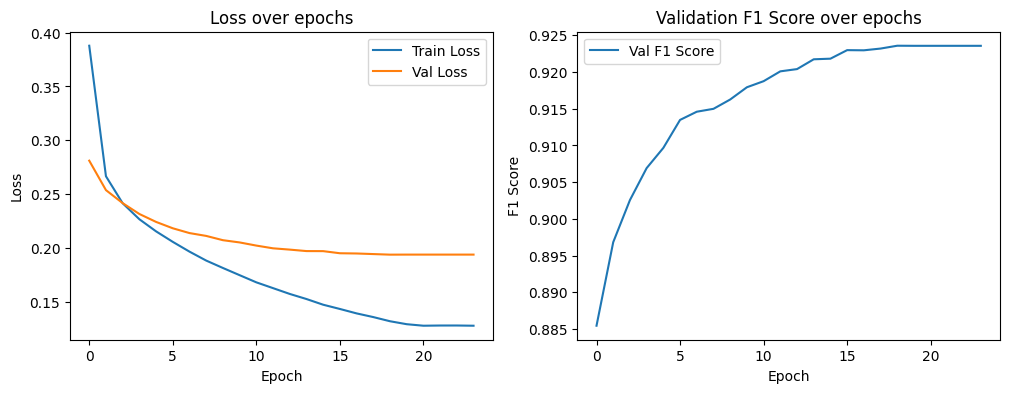

In [62]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1,2,2)
plt.plot(val_f1_scores, label='Val F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Validation F1 Score over epochs')

plt.show()


In [85]:
data_test['tfidf_clean'] = data_test['text'].apply(clean_tfidf)

In [98]:
data_test

,id,text,tfidf_clean
0,29568,"ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн...",эй влюбла нный скидка промокод syhoyz спектакл...
1,29569,Пруды Москвы,пруд москва
2,29570,🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...,семейка л гкий поведение неожиданный комедия т...
3,29571,24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...,сентябрь исторический фестиваль башкирия русь ...
4,29572,19-20 августа\nДетский клуб в кафе «Отдых»\nТе...,август детский клуб кафе отдых тематический ра...
...,...,...,...
7387,36955,Концерт «Stabat Mater»\n24 и 25 марта в 20:00\...,концерт stabat mater март кирочный ул преддвер...
7388,36956,СПЕКТАКЛЬ «ОДНАЖДЫ…»\nСпектакль для 1 зрителя....,спектакль однажды спектакль зритель любить кни...
7389,36957,вт.-пт. 10:00-20:00 можно бесплатно полетать н...,вт пт бесплатно полетать москва vr аттракцион ...
7390,36958,"ТЕАТРАЛЬНЫЙ СЕЗОН ""НА ВОДАХ""\nс 1 по 9 апреля ...",театральный сезон вода апрель год г железновод...


In [100]:

# Применяем тот же векторайзер, что и на обучении:

X_test = vectorizer.transform(data_test['tfidf_clean'].values)  
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

all_test_preds = []
with torch.no_grad():
    batch_size = 64
    for i in range(0, len(test_df), batch_size):
        batch = X_test_tensor[i:i+batch_size]
        preds = model(batch)
        all_test_preds.append(preds.cpu().numpy())

all_test_preds = np.vstack(all_test_preds)
test_preds_bin = (all_test_preds > 0.5).astype(int)
labels_str = [' '.join(map(str, row)) for row in test_preds_bin]
submission = pd.DataFrame({
    'id': test_df['id'],
    'labels': labels_str
})

submission.to_csv('submission.csv', index=False)
print('Submission saved to submission.csv')

Submission saved to submission.csv


## (2) w2v + любая нейронная сеть (~0.77)


In [101]:
df_4

,id,text,labels,tfidf_clean,w2v_clean,cnn_clean,rnn_clean,bert_clean,label_vector
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,январь детский развлекательный программа беспл...,"[январь, детский, развлекательный, программа, ...","[15, января, детская, развлекательная, програм...","[15, января, детская, развлекательная, програм...",15 января\nДетская развлекательная программа\n...,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,август выходной мег мегапарк,"[и, август, выходной, в, мег, мегапарк]","[13, и, 14, августа, выходные, в, меге, мегапарк]","[13, и, 14, августа, выходные, в, меге, мегапарк]",13 и 14 августа\nВыходные в Меге\n\nМегапарк,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ..."
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,йокнапатоф постановка театр маяковский билет р,"[йокнапатоф, постановка, театр, они, маяковски...","[йокнапатофа, постановка, театр, им., маяковск...","[йокнапатофа, постановка, театр, им., маяковск...",Йокнапатофа\nПостановка Театр им. Маяковского\...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,впервые уфа танцевальный терапия группа практи...,"[впервые, в, уфа, танцевальный, терапия, в, гр...","[впервые, в, уфе, танцевальная, терапия, в, гр...","[впервые, в, уфе, танцевальная, терапия, в, гр...",Впервые в Уфе танцевальная терапия в группе с ...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,grand piano competition друг сегодня открытие ...,"[grand, piano, competition, друг, сегодня, отк...","[grand, piano, competition, друзья,, сегодня, ...","[grand, piano, competition, друзья,, сегодня, ...","🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,выступление симфо группа teodor июль парка мег...,"[выступление, симфо, группа, teodor, июль, в, ...","[выступление, симфо-группы, teodor, 22, июля, ...","[выступление, симфо-группы, teodor, 22, июля, ...",Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ..."
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,юзикл монт кристо театр оперетта это очень ярк...,"[юзикл, монт, кристо, театр, оперетта, это, оч...","[юзикл, монте-кристо, театр, оперетты, это, оч...","[юзикл, монте-кристо, театр, оперетты, это, оч...","🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,расписание бесплатный экскурсия октябрь год г ...,"[расписание, бесплатный, экскурсия, в, октябрь...","[расписание, бесплатных, экскурсий, в, октябре...","[расписание, бесплатных, экскурсий, в, октябре...",РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,долгожданный концерт надежда кадышева рязань с...,"[долгожданный, концерт, надежда, кадышева, в, ...","[долгожданный, концерт, надежды, кадышевой, в,...","[долгожданный, концерт, надежды, кадышевой, в,...",Долгожданный концерт Надежды Кадышевой в Рязан...,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ..."


In [102]:
# 1. Получаем текст и метки
X_text = df_4['w2v_clean'].astype(str).values
y = np.array(df_4['label_vector'].tolist())

# 2. Делим на трейн и валидацию с балансом по самым активным классам
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y,
    test_size=0.15,
    random_state=42,
    stratify=y.argmax(axis=1)  # важно! обеспечиваем сбалансированность
)



In [103]:
X_text

array(["['январь', 'детский', 'развлекательный', 'программа', 'бесплатно', 'cafeotdyh', 'кафе', 'отдых', 'запись', 'обязательно']",
       "['и', 'август', 'выходной', 'в', 'мег', 'мегапарк']",
       "['йокнапатоф', 'постановка', 'театр', 'они', 'маяковский', 'билет', 'от', 'до', 'р']",
       ...,
       "['расписание', 'бесплатный', 'экскурсия', 'в', 'октябрь', 'год', 'г', 'кисловодск', 'курортный', 'осень', 'в', 'кисловодск', 'продолжаться', 'уважаемый', 'житель', 'и', 'гость', 'город', 'курорт', 'кисловодск', 'приглашать', 'вы', 'принять', 'участие', 'в', 'бесплатный', 'экскурсия', 'по', 'кисловодск', 'в', 'октябрь', 'это', 'уникальный', 'возможность', 'узнать', 'большой', 'о', 'богатый', 'история', 'культура', 'и', 'природный', 'красота', 'наш', 'курорт', 'не', 'забыть', 'заранее', 'забронировать', 'место', 'так', 'как', 'количество', 'участник', 'ограничить', 'предварительный', 'запись', 'по', 'телефон', 'управление', 'по', 'курорт', 'и', 'туризм', 'администрация', 'город', 'кур

это если самим обучать Word2Vec

In [104]:
from gensim.models import KeyedVectors


In [ ]:
w2v_model = Word2Vec(
    sentences=X_text,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)


### иду через предобученную модель word2vec (тут вообще 0.57)

In [106]:
import gensim.downloader as api
w2v_model = api.load("word2vec-ruscorpora-300")  # но она загружается онлайн


[==================================================] 100.0% 198.8/198.8MB downloaded


In [107]:
embedding_dim = w2v_model.vector_size

In [108]:
# 4. Функция преобразования текста в эмбеддинги
def vectorize_text(text_list):
    vectors = []
    for tokens in tqdm(text_list):
        words = tokens.split()
        word_vecs = [w2v_model[word] for word in words if word in w2v_model]
        if len(word_vecs) == 0:
            vectors.append(np.zeros(embedding_dim))
        else:
            vectors.append(np.mean(word_vecs, axis=0))
    return np.array(vectors)

X_train_vec = vectorize_text(X_train_text)
X_val_vec = vectorize_text(X_val_text)


100%|██████████| 4436/4436 [00:00<00:00, 18376.27it/s]


In [114]:
from torch.utils.data import Dataset, DataLoader


In [115]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_vec, y_train)
val_dataset = TextDataset(X_val_vec, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [116]:
# 6. Модель
class W2V_MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = W2V_MLP(input_dim=embedding_dim, output_dim=y.shape[1])

In [117]:
# 8. F1-мера
def calc_f1(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred_bin, average='macro')  


In [118]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score, model, path):
        score = val_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, path)
            self.counter = 0

    def save_checkpoint(self, model, path):
        if self.verbose:
            print(f"Validation score improved. Saving model to {path}")
        torch.save(model.state_dict(), path)

In [119]:
# 7. Тренировка
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

W2V_MLP(
  (model): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=20, bias=True)
    (6): Sigmoid()
  )
)

In [120]:
def lr_lambda(current_step):
    warmup_steps = 5
    total_steps = 20
    min_lr_factor = 1e-5  # минимальный множитель lr

    if current_step < warmup_steps:
        return float(current_step + 1) / float(warmup_steps)
    else:
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        cosine_decay = 0.5 * (1.0 + np.cos(np.pi * progress))
        return max(min_lr_factor, cosine_decay)


scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

early_stopping = EarlyStopping(patience=5, verbose=True)

In [123]:
# Для логов
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
lrs = []

# --- Цикл обучения ---
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    all_preds, all_labels = [], []

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    scheduler.step()

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    train_f1 = calc_f1(all_labels, all_preds)

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(yb.cpu().numpy())

    val_preds = np.vstack(val_preds)
    val_labels = np.vstack(val_labels)
    val_f1 = calc_f1(val_labels, val_preds)

    train_losses.append(train_loss / len(train_dataset))
    val_losses.append(val_loss / len(val_dataset))
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, "
          f"Train F1={train_f1:.4f}, Val F1={val_f1:.4f}, LR={lrs[-1]:.6f}")

    early_stopping(val_f1, model, 'best_w2v_model.pt')
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1 Train: 100%|██████████| 393/393 [00:00<00:00, 598.66it/s]


Epoch 1: Train Loss=0.4941, Val Loss=0.4936, Train F1=0.7991, Val F1=0.8007, LR=0.000011
Validation score improved. Saving model to best_w2v_model.pt


Epoch 2 Train: 100%|██████████| 393/393 [00:00<00:00, 593.21it/s]


Epoch 2: Train Loss=0.4941, Val Loss=0.4936, Train F1=0.7990, Val F1=0.8007, LR=0.000043
Validation score improved. Saving model to best_w2v_model.pt


Epoch 3 Train: 100%|██████████| 393/393 [00:00<00:00, 593.37it/s]


Epoch 3: Train Loss=0.4941, Val Loss=0.4936, Train F1=0.7980, Val F1=0.8007, LR=0.000095
Validation score improved. Saving model to best_w2v_model.pt


Epoch 4 Train: 100%|██████████| 393/393 [00:00<00:00, 597.66it/s]


Epoch 4: Train Loss=0.4942, Val Loss=0.4935, Train F1=0.7957, Val F1=0.8007, LR=0.000165
Validation score improved. Saving model to best_w2v_model.pt


Epoch 5 Train: 100%|██████████| 393/393 [00:00<00:00, 596.77it/s]


Epoch 5: Train Loss=0.4943, Val Loss=0.4938, Train F1=0.7979, Val F1=0.7910, LR=0.000250
EarlyStopping counter: 1 out of 5


Epoch 6 Train: 100%|██████████| 393/393 [00:00<00:00, 597.15it/s]


Epoch 6: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7941, Val F1=0.8007, LR=0.000345
Validation score improved. Saving model to best_w2v_model.pt


Epoch 7 Train: 100%|██████████| 393/393 [00:00<00:00, 595.60it/s]


Epoch 7: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7962, Val F1=0.8007, LR=0.000448
Validation score improved. Saving model to best_w2v_model.pt


Epoch 8 Train: 100%|██████████| 393/393 [00:00<00:00, 595.80it/s]


Epoch 8: Train Loss=0.4944, Val Loss=0.4940, Train F1=0.7968, Val F1=0.7910, LR=0.000552
EarlyStopping counter: 1 out of 5


Epoch 9 Train: 100%|██████████| 393/393 [00:00<00:00, 600.69it/s]


Epoch 9: Train Loss=0.4944, Val Loss=0.4940, Train F1=0.7963, Val F1=0.7910, LR=0.000655
EarlyStopping counter: 2 out of 5


Epoch 10 Train: 100%|██████████| 393/393 [00:00<00:00, 601.02it/s]


Epoch 10: Train Loss=0.4945, Val Loss=0.4936, Train F1=0.7955, Val F1=0.8007, LR=0.000750
Validation score improved. Saving model to best_w2v_model.pt


Epoch 11 Train: 100%|██████████| 393/393 [00:00<00:00, 595.96it/s]


Epoch 11: Train Loss=0.4945, Val Loss=0.4941, Train F1=0.7949, Val F1=0.7793, LR=0.000835
EarlyStopping counter: 1 out of 5


Epoch 12 Train: 100%|██████████| 393/393 [00:00<00:00, 594.10it/s]


Epoch 12: Train Loss=0.4945, Val Loss=0.4939, Train F1=0.7954, Val F1=0.8007, LR=0.000905
Validation score improved. Saving model to best_w2v_model.pt


Epoch 13 Train: 100%|██████████| 393/393 [00:00<00:00, 596.94it/s]


Epoch 13: Train Loss=0.4946, Val Loss=0.4938, Train F1=0.7956, Val F1=0.8007, LR=0.000957
Validation score improved. Saving model to best_w2v_model.pt


Epoch 14 Train: 100%|██████████| 393/393 [00:00<00:00, 594.30it/s]


Epoch 14: Train Loss=0.4945, Val Loss=0.4940, Train F1=0.7956, Val F1=0.7910, LR=0.000989
EarlyStopping counter: 1 out of 5


Epoch 15 Train: 100%|██████████| 393/393 [00:00<00:00, 592.58it/s]


Epoch 15: Train Loss=0.4946, Val Loss=0.4940, Train F1=0.7951, Val F1=0.8007, LR=0.001000
Validation score improved. Saving model to best_w2v_model.pt


Epoch 16 Train: 100%|██████████| 393/393 [00:00<00:00, 593.39it/s]


Epoch 16: Train Loss=0.4945, Val Loss=0.4938, Train F1=0.7948, Val F1=0.8007, LR=0.000989
Validation score improved. Saving model to best_w2v_model.pt


Epoch 17 Train: 100%|██████████| 393/393 [00:00<00:00, 597.67it/s]


Epoch 17: Train Loss=0.4945, Val Loss=0.4938, Train F1=0.7962, Val F1=0.8007, LR=0.000957
Validation score improved. Saving model to best_w2v_model.pt


Epoch 18 Train: 100%|██████████| 393/393 [00:00<00:00, 590.65it/s]


Epoch 18: Train Loss=0.4943, Val Loss=0.4937, Train F1=0.7949, Val F1=0.8007, LR=0.000905
Validation score improved. Saving model to best_w2v_model.pt


Epoch 19 Train: 100%|██████████| 393/393 [00:00<00:00, 594.47it/s]


Epoch 19: Train Loss=0.4942, Val Loss=0.4940, Train F1=0.7966, Val F1=0.7910, LR=0.000835
EarlyStopping counter: 1 out of 5


Epoch 20 Train: 100%|██████████| 393/393 [00:00<00:00, 602.35it/s]


Epoch 20: Train Loss=0.4943, Val Loss=0.4936, Train F1=0.7961, Val F1=0.8007, LR=0.000750
Validation score improved. Saving model to best_w2v_model.pt


Epoch 21 Train: 100%|██████████| 393/393 [00:00<00:00, 597.49it/s]


Epoch 21: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7946, Val F1=0.7910, LR=0.000655
EarlyStopping counter: 1 out of 5


Epoch 22 Train: 100%|██████████| 393/393 [00:00<00:00, 595.89it/s]


Epoch 22: Train Loss=0.4942, Val Loss=0.4938, Train F1=0.7974, Val F1=0.8007, LR=0.000552
Validation score improved. Saving model to best_w2v_model.pt


Epoch 23 Train: 100%|██████████| 393/393 [00:00<00:00, 590.05it/s]


Epoch 23: Train Loss=0.4942, Val Loss=0.4936, Train F1=0.7957, Val F1=0.8007, LR=0.000448
Validation score improved. Saving model to best_w2v_model.pt


Epoch 24 Train: 100%|██████████| 393/393 [00:00<00:00, 592.11it/s]


Epoch 24: Train Loss=0.4941, Val Loss=0.4936, Train F1=0.7958, Val F1=0.8007, LR=0.000345
Validation score improved. Saving model to best_w2v_model.pt


Epoch 25 Train: 100%|██████████| 393/393 [00:00<00:00, 578.34it/s]


Epoch 25: Train Loss=0.4941, Val Loss=0.4937, Train F1=0.7965, Val F1=0.7910, LR=0.000250
EarlyStopping counter: 1 out of 5


Epoch 26 Train: 100%|██████████| 393/393 [00:00<00:00, 583.28it/s]


Epoch 26: Train Loss=0.4941, Val Loss=0.4937, Train F1=0.7967, Val F1=0.8007, LR=0.000165
Validation score improved. Saving model to best_w2v_model.pt


Epoch 27 Train: 100%|██████████| 393/393 [00:00<00:00, 594.77it/s]


Epoch 27: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7971, Val F1=0.8007, LR=0.000095
Validation score improved. Saving model to best_w2v_model.pt


Epoch 28 Train: 100%|██████████| 393/393 [00:00<00:00, 594.46it/s]


Epoch 28: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7983, Val F1=0.8007, LR=0.000043
Validation score improved. Saving model to best_w2v_model.pt


Epoch 29 Train: 100%|██████████| 393/393 [00:00<00:00, 587.43it/s]


Epoch 29: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7991, Val F1=0.8007, LR=0.000011
Validation score improved. Saving model to best_w2v_model.pt


Epoch 30 Train: 100%|██████████| 393/393 [00:00<00:00, 589.38it/s]


Epoch 30: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7991, Val F1=0.8007, LR=0.000000
Validation score improved. Saving model to best_w2v_model.pt


Epoch 31 Train: 100%|██████████| 393/393 [00:00<00:00, 584.76it/s]


Epoch 31: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7991, Val F1=0.8007, LR=0.000011
Validation score improved. Saving model to best_w2v_model.pt


Epoch 32 Train: 100%|██████████| 393/393 [00:00<00:00, 585.43it/s]


Epoch 32: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7991, Val F1=0.8007, LR=0.000043
Validation score improved. Saving model to best_w2v_model.pt


Epoch 33 Train: 100%|██████████| 393/393 [00:00<00:00, 575.10it/s]


Epoch 33: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7991, Val F1=0.8007, LR=0.000095
Validation score improved. Saving model to best_w2v_model.pt


Epoch 34 Train: 100%|██████████| 393/393 [00:00<00:00, 584.49it/s]


Epoch 34: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7975, Val F1=0.8007, LR=0.000165
Validation score improved. Saving model to best_w2v_model.pt


Epoch 35 Train: 100%|██████████| 393/393 [00:00<00:00, 589.82it/s]


Epoch 35: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7979, Val F1=0.8007, LR=0.000250
Validation score improved. Saving model to best_w2v_model.pt


Epoch 36 Train: 100%|██████████| 393/393 [00:00<00:00, 586.72it/s]


Epoch 36: Train Loss=0.4940, Val Loss=0.4936, Train F1=0.7958, Val F1=0.8007, LR=0.000345
Validation score improved. Saving model to best_w2v_model.pt


Epoch 37 Train: 100%|██████████| 393/393 [00:00<00:00, 582.04it/s]


Epoch 37: Train Loss=0.4941, Val Loss=0.4936, Train F1=0.7958, Val F1=0.8007, LR=0.000448
Validation score improved. Saving model to best_w2v_model.pt


Epoch 38 Train: 100%|██████████| 393/393 [00:00<00:00, 592.99it/s]


Epoch 38: Train Loss=0.4941, Val Loss=0.4936, Train F1=0.7959, Val F1=0.8007, LR=0.000552
Validation score improved. Saving model to best_w2v_model.pt


Epoch 39 Train: 100%|██████████| 393/393 [00:00<00:00, 595.08it/s]


Epoch 39: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7958, Val F1=0.8007, LR=0.000655
Validation score improved. Saving model to best_w2v_model.pt


Epoch 40 Train: 100%|██████████| 393/393 [00:00<00:00, 588.72it/s]


Epoch 40: Train Loss=0.4941, Val Loss=0.4937, Train F1=0.7959, Val F1=0.8007, LR=0.000750
Validation score improved. Saving model to best_w2v_model.pt


Epoch 41 Train: 100%|██████████| 393/393 [00:00<00:00, 593.87it/s]


Epoch 41: Train Loss=0.4942, Val Loss=0.4936, Train F1=0.7963, Val F1=0.8007, LR=0.000835
Validation score improved. Saving model to best_w2v_model.pt


Epoch 42 Train: 100%|██████████| 393/393 [00:00<00:00, 597.44it/s]


Epoch 42: Train Loss=0.4942, Val Loss=0.4936, Train F1=0.7956, Val F1=0.8007, LR=0.000905
Validation score improved. Saving model to best_w2v_model.pt


Epoch 43 Train: 100%|██████████| 393/393 [00:00<00:00, 598.46it/s]


Epoch 43: Train Loss=0.4942, Val Loss=0.4936, Train F1=0.7964, Val F1=0.8007, LR=0.000957
Validation score improved. Saving model to best_w2v_model.pt


Epoch 44 Train: 100%|██████████| 393/393 [00:00<00:00, 601.89it/s]


Epoch 44: Train Loss=0.4942, Val Loss=0.4940, Train F1=0.7952, Val F1=0.7910, LR=0.000989
EarlyStopping counter: 1 out of 5


Epoch 45 Train: 100%|██████████| 393/393 [00:00<00:00, 603.39it/s]


Epoch 45: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7958, Val F1=0.8007, LR=0.001000
Validation score improved. Saving model to best_w2v_model.pt


Epoch 46 Train: 100%|██████████| 393/393 [00:00<00:00, 593.29it/s]


Epoch 46: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7951, Val F1=0.8007, LR=0.000989
Validation score improved. Saving model to best_w2v_model.pt


Epoch 47 Train: 100%|██████████| 393/393 [00:00<00:00, 591.98it/s]


Epoch 47: Train Loss=0.4942, Val Loss=0.4938, Train F1=0.7950, Val F1=0.7910, LR=0.000957
EarlyStopping counter: 1 out of 5


Epoch 48 Train: 100%|██████████| 393/393 [00:00<00:00, 600.98it/s]


Epoch 48: Train Loss=0.4942, Val Loss=0.4939, Train F1=0.7962, Val F1=0.8007, LR=0.000905
Validation score improved. Saving model to best_w2v_model.pt


Epoch 49 Train: 100%|██████████| 393/393 [00:00<00:00, 595.05it/s]


Epoch 49: Train Loss=0.4942, Val Loss=0.4939, Train F1=0.7968, Val F1=0.7910, LR=0.000835
EarlyStopping counter: 1 out of 5


Epoch 50 Train: 100%|██████████| 393/393 [00:00<00:00, 604.60it/s]


Epoch 50: Train Loss=0.4942, Val Loss=0.4937, Train F1=0.7954, Val F1=0.8007, LR=0.000750
Validation score improved. Saving model to best_w2v_model.pt


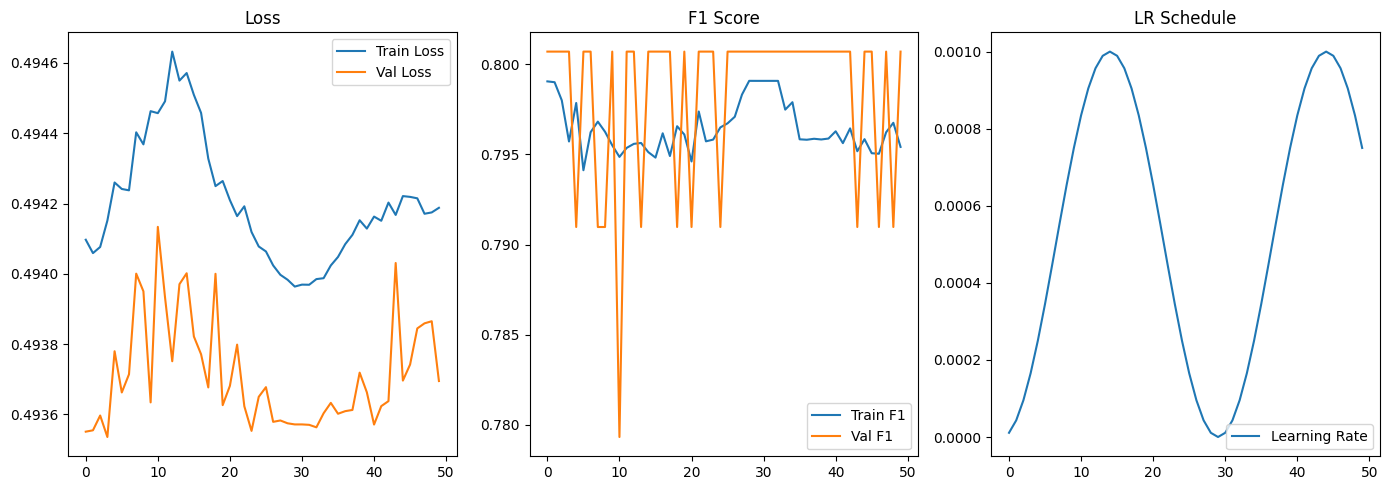

In [124]:
# --- Визуализация ---
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Val F1')
plt.legend()
plt.title('F1 Score')

plt.subplot(1,3,3)
plt.plot(lrs, label='Learning Rate')
plt.legend()
plt.title('LR Schedule')

plt.tight_layout()
plt.show()

In [127]:
data_test['w2v_clean'] = data_test['text'].apply(clean_w2v)

In [128]:
data_test

,id,text,tfidf_clean,w2v_clean
0,29568,"ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн...",эй влюбла нный скидка промокод syhoyz спектакл...,"[эй, влюбла, нный, скидка, промокод, syhoyz, н..."
1,29569,Пруды Москвы,пруд москва,"[пруд, москва]"
2,29570,🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...,семейка л гкий поведение неожиданный комедия т...,"[семейка, л, гкий, поведение, неожиданный, ком..."
3,29571,24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...,сентябрь исторический фестиваль башкирия русь ...,"[сентябрь, исторический, фестиваль, башкирия, ..."
4,29572,19-20 августа\nДетский клуб в кафе «Отдых»\nТе...,август детский клуб кафе отдых тематический ра...,"[август, детский, клуб, в, кафе, отдых, темати..."
...,...,...,...,...
7387,36955,Концерт «Stabat Mater»\n24 и 25 марта в 20:00\...,концерт stabat mater март кирочный ул преддвер...,"[концерт, stabat, mater, и, март, в, кирочный,..."
7388,36956,СПЕКТАКЛЬ «ОДНАЖДЫ…»\nСпектакль для 1 зрителя....,спектакль однажды спектакль зритель любить кни...,"[спектакль, однажды, спектакль, для, зритель, ..."
7389,36957,вт.-пт. 10:00-20:00 можно бесплатно полетать н...,вт пт бесплатно полетать москва vr аттракцион ...,"[вт, пт, можно, бесплатно, полетать, над, моск..."
7390,36958,"ТЕАТРАЛЬНЫЙ СЕЗОН ""НА ВОДАХ""\nс 1 по 9 апреля ...",театральный сезон вода апрель год г железновод...,"[театральный, сезон, на, вода, с, по, апрель, ..."


In [130]:
# 11. Предсказание для submission
model.load_state_dict(torch.load('best_w2v_model.pt'))
model.eval()

X_test_text = data_test['w2v_clean'].astype(str).values
X_test_vec = vectorize_text(X_test_text)
test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)
test_loader = DataLoader(test_tensor, batch_size=64)

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())

final_preds = np.vstack(all_preds)
final_preds_bin = (final_preds > 0.5).astype(int)

submission = pd.DataFrame({
    'id': data_test['id'],
    'labels': [" ".join(map(str, row)) for row in final_preds_bin]
})
submission.to_csv('submission.csv', index=False)


100%|██████████| 7392/7392 [00:00<00:00, 19190.98it/s]


100%|██████████| 4436/4436 [00:00<00:00, 18181.70it/s]


Epoch 1: Train Loss = 0.6920, Val Loss = 0.6920, Train F1 = 0.5702, Val F1 = 0.5829
LR: 0.000200
Initial best score: 0.6920
Epoch 2: Train Loss = 0.5157, Val Loss = 0.4938, Train F1 = 0.7892, Val F1 = 0.8007
LR: 0.000400
Improved score: 0.4938 (was 0.6920), resetting counter.
Epoch 3: Train Loss = 0.4947, Val Loss = 0.4940, Train F1 = 0.7950, Val F1 = 0.7900
LR: 0.000600
No improvement. Counter: 1/5
Epoch 4: Train Loss = 0.4948, Val Loss = 0.4941, Train F1 = 0.7947, Val F1 = 0.8007
LR: 0.000800
No improvement. Counter: 2/5
Epoch 5: Train Loss = 0.4947, Val Loss = 0.4942, Train F1 = 0.7947, Val F1 = 0.8007
LR: 0.001000
No improvement. Counter: 3/5
Epoch 6: Train Loss = 0.4949, Val Loss = 0.4944, Train F1 = 0.7942, Val F1 = 0.8007
LR: 0.000989
No improvement. Counter: 4/5
Epoch 7: Train Loss = 0.4949, Val Loss = 0.4956, Train F1 = 0.7946, Val F1 = 0.8007
LR: 0.000957
No improvement. Counter: 5/5
Early stopping triggered!
Stopped early


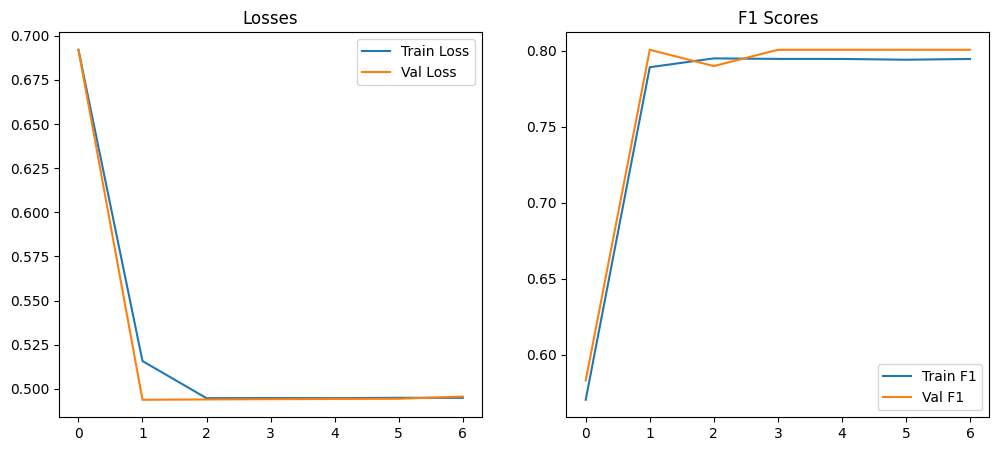

100%|██████████| 7392/7392 [00:00<00:00, 16355.43it/s]


In [133]:

# EarlyStopping класс
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            if self.verbose:
                print(f"Initial best score: {-score:.4f}")
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered!")
                self.early_stop = True
        else:
            if self.verbose:
                print(f"Improved score: {-score:.4f} (was {-self.best_score:.4f}), resetting counter.")
            self.best_score = score
            self.counter = 0

# Установка случайных сидов для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1. Получаем текст и метки
X_text = df_4['w2v_clean'].astype(str).values
y = np.array(df_4['label_vector'].tolist())

# 2. Делим на трейн и валидацию
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y,
    test_size=0.15,
    random_state=SEED,
    stratify=y.argmax(axis=1)
)

# 3. Загрузка предобученной модели Word2Vec (RusVectores)
w2v_model = api.load("word2vec-ruscorpora-300")  # но она загружается онлайн
embedding_dim = w2v_model.vector_size

# 4. Функция преобразования текста в эмбеддинги
def vectorize_text(text_list):
    vectors = []
    for tokens in tqdm(text_list):
        words = tokens.split()
        word_vecs = [w2v_model[word] for word in words if word in w2v_model]
        if len(word_vecs) == 0:
            vectors.append(np.zeros(embedding_dim))
        else:
            vectors.append(np.mean(word_vecs, axis=0))
    return np.array(vectors)

X_train_vec = vectorize_text(X_train_text)
X_val_vec = vectorize_text(X_val_text)

# 5. Dataset и DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_vec, y_train)
val_dataset = TextDataset(X_val_vec, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 6. Модель
class W2V_MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = W2V_MLP(input_dim=embedding_dim, output_dim=y.shape[1])

# 7. Оптимизатор, критерий, устройство
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 8. F1-мера
def calc_f1(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred_bin, average='macro')

# 9. LR scheduler с warmup и cosine decay
def lr_lambda(current_step):
    warmup_steps = 5
    total_steps = 20
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    else:
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 10. Ранняя остановка
early_stopping = EarlyStopping(patience=5, verbose=True)

# 11. Цикл обучения
best_val_f1 = 0
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in range(1, 21):
    model.train()
    train_loss = 0
    all_preds, all_labels = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    train_f1 = calc_f1(all_labels, all_preds)

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(yb.cpu().numpy())

    val_preds = np.vstack(val_preds)
    val_labels = np.vstack(val_labels)
    val_f1 = calc_f1(val_labels, val_preds)

    train_losses.append(train_loss / len(train_dataset))
    val_losses.append(val_loss / len(val_dataset))
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    scheduler.step()

    print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, Train F1 = {train_f1:.4f}, Val F1 = {val_f1:.4f}")
    for param_group in optimizer.param_groups:
        print(f"LR: {param_group['lr']:.6f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_w2v_model.pt')

    early_stopping(val_loss / len(val_dataset))
    if early_stopping.early_stop:
        print("Stopped early")
        break

# 12. Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Val F1')
plt.legend()
plt.title('F1 Scores')
plt.show()

# 13. Предсказание для submission
model.load_state_dict(torch.load('best_w2v_model.pt'))
model.eval()

X_test_text = data_test['w2v_clean'].astype(str).values
X_test_vec = vectorize_text(X_test_text)
test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)
test_loader = DataLoader(test_tensor, batch_size=64)

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())

final_preds = np.vstack(all_preds)
final_preds_bin = (final_preds > 0.5).astype(int)

submission = pd.DataFrame({
    'id': data_test['id'],
    'labels': [" ".join(map(str, row)) for row in final_preds_bin]
})
submission.to_csv('submission.csv', index=False)


 ## мой word2vec, без использования предобученной модели. результат на кагл 0.75, что хуже tf-idf(0.82)

In [42]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [43]:
texts = df_4['w2v_clean'].astype(str)  # один раз привели к строке
X_text = texts.values
y = np.array(df_4['label_vector'].tolist())

KeyError: 'w2v_clean'

In [44]:

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y,
    test_size=0.15,
    random_state=SEED,
    stratify=y.argmax(axis=1)
)


NameError: name 'X_text' is not defined

In [ ]:
sentences = [text.split() for text in texts]  # используем уже преобразованные строки


In [ ]:
# Обучение своей Word2Vec модели
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4, seed=SEED)
w2v_model = w2v_model.wv  
embedding_dim = w2v_model.vector_size


In [ ]:
def vectorize_text(text_list):
    vectors = []
    for tokens in tqdm(text_list):
        words = tokens.split()
        word_vecs = [w2v_model[word] for word in words if word in w2v_model]
        if len(word_vecs) == 0:
            vectors.append(np.zeros(embedding_dim))
        else:
            vectors.append(np.mean(word_vecs, axis=0))
    return np.array(vectors)


X_train_vec = vectorize_text(X_train_text)
X_val_vec = vectorize_text(X_val_text)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_vec, y_train)
val_dataset = TextDataset(X_val_vec, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:


class W2V_MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = W2V_MLP(input_dim=embedding_dim, output_dim=y.shape[1])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()


In [ ]:
def lr_lambda(current_step):
    warmup_steps = 5
    total_steps = 50
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    else:
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, path)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, path)
            self.counter = 0
            if self.verbose:
                print(f"Improved score: {-score:.4f} (was {-self.best_score:.4f}), resetting counter.")

    def save_checkpoint(self, model, path):
        torch.save(model.state_dict(), path)
        if self.verbose:
            print(f"Saved model to {path}")

early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:

# --- Функция для вычисления F1 с порогом ---
def calc_f1(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred_bin, average='macro')

# --- Поиск лучшего порога для F1 ---
def find_best_threshold(y_true, y_probs):
    best_thr = 0.5
    best_f1 = 0
    for thr in np.arange(0.1, 0.9, 0.05):
        y_pred = (y_probs > thr).astype(int)
        f1 = f1_score(y_true, y_pred, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    return best_thr, best_f1

100%|██████████| 4436/4436 [00:00<00:00, 5785.69it/s]


Epoch 1: Train Loss = 0.6942, Val Loss = 0.6940, Train F1 = 0.5329, Val F1 = 0.6927, Best Thr = 0.10, LR = 0.000000
Saved model to best_w2v_model.pt
Epoch 2: Train Loss = 0.5404, Val Loss = 0.4347, Train F1 = 0.7796, Val F1 = 0.8287, Best Thr = 0.50, LR = 0.000020
Saved model to best_w2v_model.pt
Improved score: 0.4347 (was 0.4347), resetting counter.
Epoch 3: Train Loss = 0.3920, Val Loss = 0.3647, Train F1 = 0.8401, Val F1 = 0.8530, Best Thr = 0.45, LR = 0.000040
Saved model to best_w2v_model.pt
Improved score: 0.3647 (was 0.3647), resetting counter.
Epoch 4: Train Loss = 0.3496, Val Loss = 0.3324, Train F1 = 0.8565, Val F1 = 0.8644, Best Thr = 0.50, LR = 0.000060
Saved model to best_w2v_model.pt
Improved score: 0.3324 (was 0.3324), resetting counter.
Epoch 5: Train Loss = 0.3248, Val Loss = 0.3140, Train F1 = 0.8671, Val F1 = 0.8722, Best Thr = 0.45, LR = 0.000080
Saved model to best_w2v_model.pt
Improved score: 0.3140 (was 0.3140), resetting counter.
Epoch 6: Train Loss = 0.3094, V

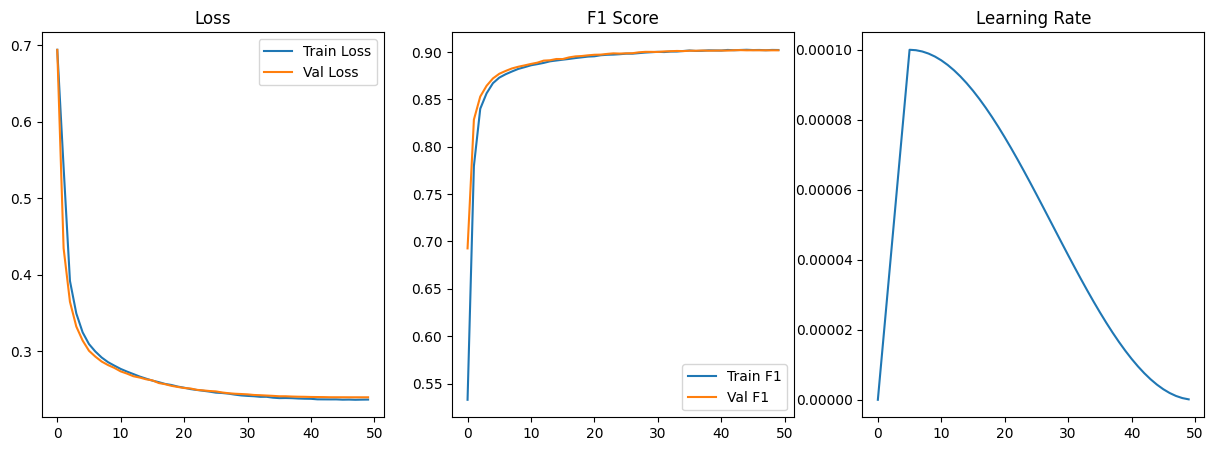

100%|██████████| 7392/7392 [00:01<00:00, 5682.03it/s]


In [136]:

n_epochs = 50
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
lrs = []

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    all_preds, all_labels = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    train_f1 = calc_f1(all_labels, all_preds)

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(yb.cpu().numpy())

    val_preds = np.vstack(val_preds)
    val_labels = np.vstack(val_labels)

    best_thr, val_f1 = find_best_threshold(val_labels, val_preds)

    train_losses.append(train_loss / len(train_dataset))
    val_losses.append(val_loss / len(val_dataset))
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

    print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, "
          f"Train F1 = {train_f1:.4f}, Val F1 = {val_f1:.4f}, Best Thr = {best_thr:.2f}, LR = {current_lr:.6f}")

    early_stopping(val_losses[-1], model, 'best_w2v_model.pt')
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    scheduler.step()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,3,2)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Val F1')
plt.legend()
plt.title('F1 Score')

plt.subplot(1,3,3)
plt.plot(lrs)
plt.title('Learning Rate')

plt.show()

model.load_state_dict(torch.load('best_w2v_model.pt'))
model.eval()

X_test_text = data_test['w2v_clean'].astype(str).values
X_test_vec = vectorize_text(X_test_text)
test_tensor = torch.tensor(X_test_vec, dtype=torch.float32)
test_loader = DataLoader(test_tensor, batch_size=64)

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())

final_preds = np.vstack(all_preds)
final_preds_bin = (final_preds > 0.5).astype(int)

submission = pd.DataFrame({
    'id': data_test['id'],
    'labels': [" ".join(map(str, row)) for row in final_preds_bin]
})
submission.to_csv('submission.csv', index=False)


## 3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях;

In [47]:
df_4

,id,text,labels,label_vector,cnn_clean,rnn_clean,bert_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[15, января, детская, развлекательная, програм...","[15, января, детская, развлекательная, програм...",15 января\nДетская развлекательная программа\n...
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...","[13, и, 14, августа, выходные, в, меге, мегапарк]","[13, и, 14, августа, выходные, в, меге, мегапарк]",13 и 14 августа\nВыходные в Меге\n\nМегапарк
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[йокнапатофа, постановка, театр, им., маяковск...","[йокнапатофа, постановка, театр, им., маяковск...",Йокнапатофа\nПостановка Театр им. Маяковского\...
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[впервые, в, уфе, танцевальная, терапия, в, гр...","[впервые, в, уфе, танцевальная, терапия, в, гр...",Впервые в Уфе танцевальная терапия в группе с ...
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[grand, piano, competition, друзья,, сегодня, ...","[grand, piano, competition, друзья,, сегодня, ...","🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня..."
...,...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[выступление, симфо-группы, teodor, 22, июля, ...","[выступление, симфо-группы, teodor, 22, июля, ...",Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[юзикл, монте-кристо, театр, оперетты, это, оч...","[юзикл, монте-кристо, театр, оперетты, это, оч...","🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[расписание, бесплатных, экскурсий, в, октябре...","[расписание, бесплатных, экскурсий, в, октябре...",РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[долгожданный, концерт, надежды, кадышевой, в,...","[долгожданный, концерт, надежды, кадышевой, в,...",Долгожданный концерт Надежды Кадышевой в Рязан...


In [52]:
# 1. Получаем текст и метки
X_text = df_4['cnn_clean'].astype(str).values
y = np.array(df_4['label_vector'].tolist())

# 2. Делим на трейн и валидацию с балансом по самым активным классам
X_train, X_val, y_train, y_val = train_test_split(
    X_text, y,
    test_size=0.15,
    random_state=42,
    stratify=y.argmax(axis=1)  # важно! обеспечиваем сбалансированность
)



Epoch 1/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 963.30it/s]



Epoch 1/100
Train Loss: 0.5800 | Val Loss: 0.4728 | Val F1 (micro): 0.5727
New best model found


Epoch 2/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 975.42it/s]



Epoch 2/100
Train Loss: 0.4587 | Val Loss: 0.4210 | Val F1 (micro): 0.6508
New best model found


Epoch 3/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 972.46it/s]



Epoch 3/100
Train Loss: 0.4236 | Val Loss: 0.4005 | Val F1 (micro): 0.6601
New best model found


Epoch 4/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 969.71it/s]



Epoch 4/100
Train Loss: 0.4074 | Val Loss: 0.3903 | Val F1 (micro): 0.6628
New best model found


Epoch 5/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 978.03it/s]



Epoch 5/100
Train Loss: 0.3999 | Val Loss: 0.3838 | Val F1 (micro): 0.6650
New best model found


Epoch 6/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 964.55it/s]



Epoch 6/100
Train Loss: 0.3938 | Val Loss: 0.3801 | Val F1 (micro): 0.6665
New best model found


Epoch 7/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 996.74it/s]



Epoch 7/100
Train Loss: 0.3885 | Val Loss: 0.3760 | Val F1 (micro): 0.6670
New best model found


Epoch 8/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 968.44it/s]



Epoch 8/100
Train Loss: 0.3843 | Val Loss: 0.3729 | Val F1 (micro): 0.6672
New best model found


Epoch 9/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 969.18it/s]



Epoch 9/100
Train Loss: 0.3812 | Val Loss: 0.3691 | Val F1 (micro): 0.6683
New best model found


Epoch 10/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 997.39it/s]



Epoch 10/100
Train Loss: 0.3791 | Val Loss: 0.3690 | Val F1 (micro): 0.6681


Epoch 11/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 990.18it/s]



Epoch 11/100
Train Loss: 0.3763 | Val Loss: 0.3663 | Val F1 (micro): 0.6682


Epoch 12/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 992.98it/s]



Epoch 12/100
Train Loss: 0.3746 | Val Loss: 0.3656 | Val F1 (micro): 0.6666


Epoch 13/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 988.03it/s]



Epoch 13/100
Train Loss: 0.3724 | Val Loss: 0.3675 | Val F1 (micro): 0.6663


Epoch 14/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 965.20it/s]



Epoch 14/100
Train Loss: 0.3715 | Val Loss: 0.3609 | Val F1 (micro): 0.6703
New best model found


Epoch 15/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 984.22it/s]



Epoch 15/100
Train Loss: 0.3697 | Val Loss: 0.3614 | Val F1 (micro): 0.6784
New best model found


Epoch 16/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 991.47it/s]



Epoch 16/100
Train Loss: 0.3678 | Val Loss: 0.3629 | Val F1 (micro): 0.6805
New best model found


Epoch 17/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 988.46it/s]



Epoch 17/100
Train Loss: 0.3668 | Val Loss: 0.3592 | Val F1 (micro): 0.6839
New best model found


Epoch 18/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 965.44it/s]



Epoch 18/100
Train Loss: 0.3655 | Val Loss: 0.3565 | Val F1 (micro): 0.6875
New best model found


Epoch 19/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 1003.65it/s]



Epoch 19/100
Train Loss: 0.3645 | Val Loss: 0.3556 | Val F1 (micro): 0.6945
New best model found


Epoch 20/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 979.98it/s]



Epoch 20/100
Train Loss: 0.3634 | Val Loss: 0.3567 | Val F1 (micro): 0.6909


Epoch 21/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 947.58it/s]



Epoch 21/100
Train Loss: 0.3628 | Val Loss: 0.3536 | Val F1 (micro): 0.6969
New best model found


Epoch 22/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 957.04it/s]



Epoch 22/100
Train Loss: 0.3612 | Val Loss: 0.3520 | Val F1 (micro): 0.6990
New best model found


Epoch 23/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 965.20it/s]



Epoch 23/100
Train Loss: 0.3606 | Val Loss: 0.3508 | Val F1 (micro): 0.6987


Epoch 24/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 990.52it/s]



Epoch 24/100
Train Loss: 0.3604 | Val Loss: 0.3521 | Val F1 (micro): 0.6997
New best model found


Epoch 25/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 994.62it/s]



Epoch 25/100
Train Loss: 0.3594 | Val Loss: 0.3505 | Val F1 (micro): 0.7005
New best model found


Epoch 26/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 1001.45it/s]



Epoch 26/100
Train Loss: 0.3592 | Val Loss: 0.3499 | Val F1 (micro): 0.7005
New best model found


Epoch 27/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 990.70it/s]



Epoch 27/100
Train Loss: 0.3576 | Val Loss: 0.3490 | Val F1 (micro): 0.7007
New best model found


Epoch 28/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 967.76it/s]



Epoch 28/100
Train Loss: 0.3575 | Val Loss: 0.3482 | Val F1 (micro): 0.6986


Epoch 29/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 964.56it/s]



Epoch 29/100
Train Loss: 0.3560 | Val Loss: 0.3476 | Val F1 (micro): 0.7016
New best model found


Epoch 30/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 997.17it/s]



Epoch 30/100
Train Loss: 0.3545 | Val Loss: 0.3455 | Val F1 (micro): 0.7015


Epoch 31/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 992.92it/s]



Epoch 31/100
Train Loss: 0.3551 | Val Loss: 0.3467 | Val F1 (micro): 0.7011


Epoch 32/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 993.57it/s]



Epoch 32/100
Train Loss: 0.3539 | Val Loss: 0.3457 | Val F1 (micro): 0.7016


Epoch 33/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 993.77it/s]



Epoch 33/100
Train Loss: 0.3534 | Val Loss: 0.3446 | Val F1 (micro): 0.7030
New best model found


Epoch 34/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 965.88it/s]



Epoch 34/100
Train Loss: 0.3533 | Val Loss: 0.3444 | Val F1 (micro): 0.7027


Epoch 35/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 949.46it/s]



Epoch 35/100
Train Loss: 0.3528 | Val Loss: 0.3435 | Val F1 (micro): 0.7035
New best model found


Epoch 36/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 991.76it/s]



Epoch 36/100
Train Loss: 0.3519 | Val Loss: 0.3435 | Val F1 (micro): 0.7024


Epoch 37/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 998.33it/s]



Epoch 37/100
Train Loss: 0.3509 | Val Loss: 0.3426 | Val F1 (micro): 0.7025


Epoch 38/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 1004.48it/s]



Epoch 38/100
Train Loss: 0.3516 | Val Loss: 0.3434 | Val F1 (micro): 0.7037
New best model found


Epoch 39/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 958.29it/s]



Epoch 39/100
Train Loss: 0.3498 | Val Loss: 0.3444 | Val F1 (micro): 0.7007


Epoch 40/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 860.84it/s]



Epoch 40/100
Train Loss: 0.3500 | Val Loss: 0.3425 | Val F1 (micro): 0.7027


Epoch 41/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 959.77it/s]



Epoch 41/100
Train Loss: 0.3505 | Val Loss: 0.3417 | Val F1 (micro): 0.7033


Epoch 42/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 989.53it/s]



Epoch 42/100
Train Loss: 0.3500 | Val Loss: 0.3411 | Val F1 (micro): 0.7053
New best model found


Epoch 43/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 964.28it/s]



Epoch 43/100
Train Loss: 0.3496 | Val Loss: 0.3412 | Val F1 (micro): 0.7032


Epoch 44/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 967.77it/s]



Epoch 44/100
Train Loss: 0.3483 | Val Loss: 0.3404 | Val F1 (micro): 0.7023


Epoch 45/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 963.53it/s]



Epoch 45/100
Train Loss: 0.3481 | Val Loss: 0.3389 | Val F1 (micro): 0.7039


Epoch 46/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 1003.79it/s]


Epoch 46/100
Train Loss: 0.3477 | Val Loss: 0.3390 | Val F1 (micro): 0.7057


New best model found


Epoch 47/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 979.92it/s]



Epoch 47/100
Train Loss: 0.3479 | Val Loss: 0.3388 | Val F1 (micro): 0.7053


Epoch 48/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 984.47it/s]



Epoch 48/100
Train Loss: 0.3471 | Val Loss: 0.3388 | Val F1 (micro): 0.7047


Epoch 49/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 997.75it/s]



Epoch 49/100
Train Loss: 0.3466 | Val Loss: 0.3369 | Val F1 (micro): 0.7040


Epoch 50/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 972.54it/s]



Epoch 50/100
Train Loss: 0.3460 | Val Loss: 0.3374 | Val F1 (micro): 0.7055


Epoch 51/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 984.99it/s]



Epoch 51/100
Train Loss: 0.3463 | Val Loss: 0.3364 | Val F1 (micro): 0.7066
New best model found


Epoch 52/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 998.07it/s]



Epoch 52/100
Train Loss: 0.3455 | Val Loss: 0.3371 | Val F1 (micro): 0.7033


Epoch 53/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 989.80it/s]



Epoch 53/100
Train Loss: 0.3457 | Val Loss: 0.3391 | Val F1 (micro): 0.7048


Epoch 54/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 966.88it/s]



Epoch 54/100
Train Loss: 0.3459 | Val Loss: 0.3363 | Val F1 (micro): 0.7056


Epoch 55/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 969.37it/s]



Epoch 55/100
Train Loss: 0.3455 | Val Loss: 0.3365 | Val F1 (micro): 0.7058


Epoch 56/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 995.61it/s]



Epoch 56/100
Train Loss: 0.3445 | Val Loss: 0.3353 | Val F1 (micro): 0.7081
New best model found


Epoch 57/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 967.29it/s]



Epoch 57/100
Train Loss: 0.3441 | Val Loss: 0.3365 | Val F1 (micro): 0.7066


Epoch 58/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 980.56it/s]



Epoch 58/100
Train Loss: 0.3444 | Val Loss: 0.3346 | Val F1 (micro): 0.7063


Epoch 59/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 998.47it/s]



Epoch 59/100
Train Loss: 0.3439 | Val Loss: 0.3344 | Val F1 (micro): 0.7070


Epoch 60/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 986.05it/s]



Epoch 60/100
Train Loss: 0.3436 | Val Loss: 0.3360 | Val F1 (micro): 0.7069


Epoch 61/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 989.73it/s]



Epoch 61/100
Train Loss: 0.3431 | Val Loss: 0.3333 | Val F1 (micro): 0.7083
New best model found


Epoch 62/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 992.74it/s]



Epoch 62/100
Train Loss: 0.3420 | Val Loss: 0.3334 | Val F1 (micro): 0.7078


Epoch 63/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 989.51it/s]



Epoch 63/100
Train Loss: 0.3428 | Val Loss: 0.3370 | Val F1 (micro): 0.7033


Epoch 64/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 976.49it/s]



Epoch 64/100
Train Loss: 0.3424 | Val Loss: 0.3336 | Val F1 (micro): 0.7075


Epoch 65/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 969.32it/s]



Epoch 65/100
Train Loss: 0.3409 | Val Loss: 0.3322 | Val F1 (micro): 0.7084
New best model found


Epoch 66/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 968.14it/s]



Epoch 66/100
Train Loss: 0.3404 | Val Loss: 0.3336 | Val F1 (micro): 0.7063


Epoch 67/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 998.95it/s]



Epoch 67/100
Train Loss: 0.3408 | Val Loss: 0.3320 | Val F1 (micro): 0.7101
New best model found


Epoch 68/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 996.14it/s]



Epoch 68/100
Train Loss: 0.3402 | Val Loss: 0.3324 | Val F1 (micro): 0.7073


Epoch 69/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 1007.88it/s]



Epoch 69/100
Train Loss: 0.3404 | Val Loss: 0.3323 | Val F1 (micro): 0.7072


Epoch 70/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 980.41it/s]



Epoch 70/100
Train Loss: 0.3407 | Val Loss: 0.3312 | Val F1 (micro): 0.7086


Epoch 71/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 996.21it/s]



Epoch 71/100
Train Loss: 0.3400 | Val Loss: 0.3324 | Val F1 (micro): 0.7078


Epoch 72/100 - Validation: 100%|██████████| 70/70 [00:00<00:00, 1003.36it/s]


Epoch 72/100
Train Loss: 0.3399 | Val Loss: 0.3310 | Val F1 (micro): 0.7089
Early stopping triggered.


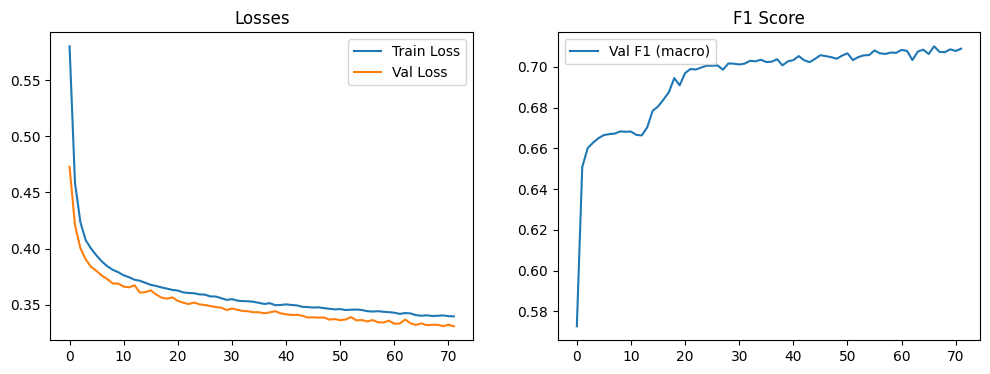

<All keys matched successfully>

In [57]:


# ==== Настройки ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 5
MODEL_PATH = "best_cnn_model.pt"
WARMUP_EPOCHS = 3
MAX_LEN = 200
EMBEDDING_DIM = 100

# ==== Предобработка ====
all_tokens = [token for sentence in X_train for token in sentence]
vocab = {"<PAD>": 0, "<UNK>": 1}
for token, count in Counter(all_tokens).items():
    if count >= 2:
        vocab[token] = len(vocab)

def encode(tokens, vocab, max_len=MAX_LEN):
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

tokenized_train = list(X_train)
tokenized_val = list(X_val)

X_train_encoded = [encode(tokens, vocab) for tokens in tokenized_train]
X_val_encoded = [encode(tokens, vocab) for tokens in tokenized_val]

class TextDatasetCNN(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDatasetCNN(X_train_encoded, y_train)
val_dataset = TextDatasetCNN(X_val_encoded, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

NUM_CLASSES = y_train.shape[1]

class CNNTextClassifierImproved(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.conv_block = nn.Sequential(
            nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)  # No Sigmoid here
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = self.conv_block(x)
        return self.classifier(x)

model = CNNTextClassifierImproved(len(vocab), EMBEDDING_DIM, NUM_CLASSES).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
epochs_no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    preds = np.vstack(all_preds) > 0.5
    targets = np.vstack(all_labels)
    val_f1 = f1_score(targets, preds, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1 (macro): {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print("New best model found")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epoch > WARMUP_EPOCHS and epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 (macro)')
plt.title('F1 Score')
plt.legend()
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))

## (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [58]:


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
EMBED_DIM = 100
HIDDEN_DIM = 128

# Простой токенизатор и построение словаря
def tokenize(text):
    return text.lower().split()

def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def encode(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens][:MAX_LEN]

# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.inputs = [encode(text, vocab) for text in texts]
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        ids = self.inputs[idx]
        padded = ids + [0] * (MAX_LEN - len(ids))
        return {
            "input_ids": torch.tensor(padded, dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Модель
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        _, (hidden, _) = self.lstm(embedded)
        output = self.dropout(hidden[-1])
        return self.fc(output)

# Обучение
def train_lstm_model(df, loss_type="bce"):
    texts = df["text"].tolist()
    labels = df["label_vector"].tolist()
    vocab = build_vocab(texts)

    X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)
    train_dataset = TextDataset(X_train, y_train, vocab)
    val_dataset = TextDataset(X_val, y_val, vocab)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    num_labels = len(df["label_vector"].iloc[0])
    model = LSTMClassifier(len(vocab), EMBED_DIM, HIDDEN_DIM, num_labels).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    if loss_type == "focal":
        def focal_loss(logits, labels, alpha=1, gamma=2):
            bce = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction='none')
            pt = torch.exp(-bce)
            loss = alpha * (1 - pt) ** gamma * bce
            return loss.mean()
        loss_fn = focal_loss
    else:
        loss_fn = lambda logits, labels: nn.functional.binary_cross_entropy_with_logits(logits, labels)

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)
                logits = model(input_ids)
                preds = torch.sigmoid(logits).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(labels.cpu().numpy())

        preds_bin = (np.array(all_preds) > 0.5).astype(int)
        macro_f1 = f1_score(all_targets, preds_bin, average="macro")
        micro_f1 = f1_score(all_targets, preds_bin, average="micro")
        print(f"Macro F1: {macro_f1:.4f}, Micro F1: {micro_f1:.4f}")


In [59]:
train_lstm_model(df_5, loss_type="bce")  # или "focal"


Epoch 1, Loss: 0.3466
Macro F1: 0.6784, Micro F1: 0.8573
Epoch 2, Loss: 0.3167
Macro F1: 0.6972, Micro F1: 0.8714
Epoch 3, Loss: 0.2832
Macro F1: 0.7330, Micro F1: 0.8887
Epoch 4, Loss: 0.2609
Macro F1: 0.7358, Micro F1: 0.8937
Epoch 5, Loss: 0.2423
Macro F1: 0.7396, Micro F1: 0.8978


## (5) эмбеддер + решение на bert-like моделях (любой вид). 0.88 кагл - лучшая моделька

## sberbank-ai/ruBert-base
https://geekr.vercel.app/company/sberdevices/blog/567776

In [40]:
##%pip install transformers


In [57]:


MODEL_NAME = "sberbank-ai/ruBert-base"  #DeepPavlov/rubert-base-cased #ai-forever/ruBert-large #ointegrated/rubert-tiny2 #sberbank-ai/ruRoberta-large
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 15
EARLY_STOPPING = 3
LR = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOSS_TYPE = "focal"  # 'bce' or 'focal'

class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['bert_clean'].tolist()
        self.labels = df['label_vector'].tolist()
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.texts)

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(self.dropout(pooled))

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()

def compute_metrics(preds, targets):
    preds = (preds > 0.5).astype(int)
    return f1_score(targets, preds, average='macro')

def train_model(df_4, loss_type="bce"):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    df = df_4.sample(frac=1.0, random_state=42).reset_index(drop=True)

    # Split
    val_frac = 0.15
    val_size = int(len(df) * val_frac)
    train_df = df[:-val_size]
    val_df = df[-val_size:]

    train_ds = TextDataset(train_df, tokenizer)
    val_ds = TextDataset(val_df, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    num_labels = len(df['label_vector'].iloc[0])
    model = BERTClassifier(MODEL_NAME, num_labels).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader) * EPOCHS),
        num_training_steps=len(train_loader) * EPOCHS
    )

    if loss_type == "focal":
        criterion = FocalLoss()
    else:
        # Без eval(), т.к. label_vector — уже список
        all_labels = np.array(df['label_vector'].tolist())
        pos_weight = torch.tensor(
            (all_labels.shape[0] - all_labels.sum(axis=0)) / (all_labels.sum(axis=0) + 1e-6),
            dtype=torch.float
        ).to(DEVICE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_score = 0
    patience = 0
    train_losses, val_losses, val_scores = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                all_preds.append(torch.sigmoid(logits).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        preds = np.vstack(all_preds)
        targets = np.vstack(all_labels)
        score = compute_metrics(preds, targets)
        val_scores.append(score)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Score: {score:.4f}")

        if score > best_val_score:
            best_val_score = score
            patience = 0
            torch.save(model.state_dict(), "best_model_bert.pt")
            print("Saved best model")
        else:
            patience += 1
            if patience >= EARLY_STOPPING:
                print("Early stopping")
                break

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_scores, label="F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    plt.show()


In [58]:
##%pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118


In [59]:
df_5

,id,text,labels,bert_clean,label_vector,num_labels,rnn_clean
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,15 января\nДетская развлекательная программа\n...,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",9,"[15, января, детская, развлекательная, програм..."
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,13 и 14 августа\nВыходные в Меге\n\nМегапарк,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...",7,"[13, и, 14, августа, выходные, в, меге, мегапарк]"
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,Йокнапатофа\nПостановка Театр им. Маяковского\...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",6,"[йокнапатофа, постановка, театр, им., маяковск..."
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,Впервые в Уфе танцевальная терапия в группе с ...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",13,"[впервые, в, уфе, танцевальная, терапия, в, гр..."
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",11,"[grand, piano, competition, друзья,, сегодня, ..."
...,...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",7,"[выступление, симфо-группы, teodor, 22, июля, ..."
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...",12,"[юзикл, монте-кристо, театр, оперетты, это, оч..."
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",15,"[расписание, бесплатных, экскурсий, в, октябре..."
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0,Долгожданный концерт Надежды Кадышевой в Рязан...,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...",10,"[долгожданный, концерт, надежды, кадышевой, в,..."


Epoch 1: 100%|██████████| 1571/1571 [08:52<00:00,  2.95it/s]


Epoch 1 | Train Loss: 0.0890 | Val Loss: 0.0541 | F1 Score: 0.7801
Saved best model


Epoch 2: 100%|██████████| 1571/1571 [08:53<00:00,  2.95it/s]


Epoch 2 | Train Loss: 0.0465 | Val Loss: 0.0366 | F1 Score: 0.8212
Saved best model


Epoch 3: 100%|██████████| 1571/1571 [08:53<00:00,  2.95it/s]


Epoch 3 | Train Loss: 0.0324 | Val Loss: 0.0331 | F1 Score: 0.8418
Saved best model


Epoch 4: 100%|██████████| 1571/1571 [08:53<00:00,  2.95it/s]


Epoch 4 | Train Loss: 0.0242 | Val Loss: 0.0296 | F1 Score: 0.8550
Saved best model


Epoch 5: 100%|██████████| 1571/1571 [08:53<00:00,  2.94it/s]


Epoch 5 | Train Loss: 0.0182 | Val Loss: 0.0303 | F1 Score: 0.8754
Saved best model


Epoch 6: 100%|██████████| 1571/1571 [08:53<00:00,  2.95it/s]


Epoch 6 | Train Loss: 0.0135 | Val Loss: 0.0320 | F1 Score: 0.8675


Epoch 7: 100%|██████████| 1571/1571 [08:53<00:00,  2.94it/s]


Epoch 7 | Train Loss: 0.0101 | Val Loss: 0.0335 | F1 Score: 0.8706


Epoch 8: 100%|██████████| 1571/1571 [08:54<00:00,  2.94it/s]


Epoch 8 | Train Loss: 0.0077 | Val Loss: 0.0357 | F1 Score: 0.8722
Early stopping


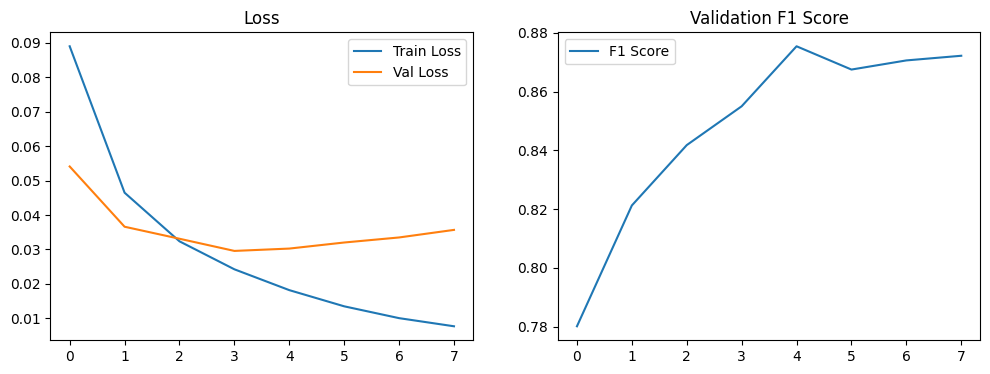

In [60]:
train_model(df_5, loss_type="focal")  # или 'bce'


In [61]:
def clean_bert(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # удаляем только URL
    # не меняем регистр, не трогаем пунктуацию, смайлы и прочее
    return text

In [62]:
data_test['bert_clean'] = data_test['text'].apply(clean_bert)


In [63]:
# Загружаем токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = BERTClassifier(MODEL_NAME, num_labels=len(df_4['label_vector'].iloc[0]))
model.load_state_dict(torch.load('best_model_bert.pt'))
model.to(DEVICE)
model.eval()

# Токенизируем тестовые данные
texts = data_test['bert_clean'].tolist()  # или 'bert_clean', если у тебя другая колонка
batch_size = 64
all_test_preds = []

with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].to(DEVICE)
        attention_mask = inputs['attention_mask'].to(DEVICE)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_test_preds.append(probs)

# Склеиваем предсказания
all_test_preds = np.vstack(all_test_preds)

# Переводим вероятности в 0 и 1 (порог 0.5)
test_preds_bin = (all_test_preds > 0.5).astype(int)

# Превращаем каждую строку в формат '0 1 0 0 1 ...'
labels_str = [' '.join(map(str, row)) for row in test_preds_bin]

# Собираем submission
submission = pd.DataFrame({
    'id': data_test['id'],
    'labels': labels_str
})

submission.to_csv('submission.csv', index=False)
print('Submission saved to submission.csv')


✅ Submission saved to submission.csv


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## та же модель, но с дополнительными, сгенерированными текстами 

In [19]:
# не успела дообучить, но даже по валидации видно, что она медленнее обучается, чем без доп данных.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, get_cosine_schedule_with_warmup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm import tqdm
from collections import Counter

MODEL_NAME = "sberbank-ai/ruBert-base"
GEN_MODEL_NAME = "ai-forever/rugpt2large"
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 15
EARLY_STOPPING = 3
LR = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOSS_TYPE = "focal"

class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['bert_clean'].tolist()
        self.labels = df['label_vector'].tolist()
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.texts)

class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(self.dropout(pooled))

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()

def compute_metrics(preds, targets):
    preds = (preds > 0.5).astype(int)
    return f1_score(targets, preds, average='macro')

def generate_text(prompt, gen_tokenizer, gen_model, max_len=100):
    inputs = gen_tokenizer(prompt, return_tensors="pt").to(DEVICE)
    outputs = gen_model.generate(
        **inputs,
        max_length=max_len,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)



# собственно 4 пункт задания




def generate_augmented_data(df, n=1000):
    # Группируем метки и считаем частоты
    label_counter = Counter(tuple(label) for label in df['label_vector'])
    unique_labels = list(label_counter.keys())
    label_weights = np.array(list(label_counter.values())) / sum(label_counter.values())

    # Сэмплируем индексы меток
    sampled_indices = np.random.choice(len(unique_labels), size=n, p=label_weights)
    sampled_labels = [list(unique_labels[i]) for i in sampled_indices]

    # Модель генерации
    gen_tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL_NAME)
    gen_model = AutoModelForCausalLM.from_pretrained(GEN_MODEL_NAME).to(DEVICE)

    augmented_texts = []
    augmented_labels = []

    for label_vec in tqdm(sampled_labels, desc="Generating synthetic data"):
        prompt = "Текст с метками: " + ", ".join([str(i) for i, val in enumerate(label_vec) if val == 1]) + ". Текст:"

        inputs = gen_tokenizer(prompt, return_tensors="pt").to(DEVICE)
        outputs = gen_model.generate(
            **inputs,
            max_length=100,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            num_return_sequences=1
        )
        text = gen_tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated = text.replace(prompt, "").strip()

        augmented_texts.append(generated)
        augmented_labels.append(label_vec)

    df_aug = pd.DataFrame({
        "bert_clean": augmented_texts,
        "label_vector": augmented_labels
    })
    return df_aug

def train_model(df_4, loss_type="bce", use_augmentation=False):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    if use_augmentation:
        df_aug = generate_augmented_data(df_4, n=1000)
        df_4 = pd.concat([df_4, df_aug], ignore_index=True)

    df = df_4.sample(frac=1.0, random_state=42).reset_index(drop=True)
    val_frac = 0.15
    val_size = int(len(df) * val_frac)
    train_df = df[:-val_size]
    val_df = df[-val_size:]

    train_ds = TextDataset(train_df, tokenizer)
    val_ds = TextDataset(val_df, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    num_labels = len(df['label_vector'].iloc[0])
    model = BERTClassifier(MODEL_NAME, num_labels).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader) * EPOCHS),
        num_training_steps=len(train_loader) * EPOCHS
    )

    if loss_type == "focal":
        criterion = FocalLoss()
    else:
        all_labels = np.array(df['label_vector'].tolist())
        pos_weight = torch.tensor(
            (all_labels.shape[0] - all_labels.sum(axis=0)) / (all_labels.sum(axis=0) + 1e-6),
            dtype=torch.float
        ).to(DEVICE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_score = 0
    patience = 0
    train_losses, val_losses, val_scores = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                all_preds.append(torch.sigmoid(logits).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        preds = np.vstack(all_preds)
        targets = np.vstack(all_labels)
        score = compute_metrics(preds, targets)
        val_scores.append(score)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Score: {score:.4f}")

        if score > best_val_score:
            best_val_score = score
            patience = 0
            torch.save(model.state_dict(), "best_model_bert.pt")
            print("Saved best model")
        else:
            patience += 1
            if patience >= EARLY_STOPPING:
                print("Early stopping")
                break

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_scores, label="F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    plt.show()


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
train_model(df_5, loss_type="focal", use_augmentation=True)


2025-05-18 18:16:17.881375: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 18:16:19.777586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 18:16:25.309298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
IOStream.flush timed out
Epoch 1: 100%|██████████| 1624/1624 [09:24<00:00,  2.88it/s]


Epoch 1 | Train Loss: 0.0881 | Val Loss: 0.0569 | F1 Score: 0.7684
Saved best model


Epoch 2: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 2 | Train Loss: 0.0493 | Val Loss: 0.0408 | F1 Score: 0.8002
Saved best model


Epoch 3: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 3 | Train Loss: 0.0356 | Val Loss: 0.0339 | F1 Score: 0.8375
Saved best model


Epoch 4: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 4 | Train Loss: 0.0270 | Val Loss: 0.0334 | F1 Score: 0.8472
Saved best model


Epoch 5: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 5 | Train Loss: 0.0207 | Val Loss: 0.0346 | F1 Score: 0.8535
Saved best model


Epoch 6: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 6 | Train Loss: 0.0157 | Val Loss: 0.0353 | F1 Score: 0.8643
Saved best model


Epoch 7: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 7 | Train Loss: 0.0121 | Val Loss: 0.0389 | F1 Score: 0.8617


Epoch 9: 100%|██████████| 1624/1624 [09:21<00:00,  2.89it/s]


Epoch 9 | Train Loss: 0.0075 | Val Loss: 0.0429 | F1 Score: 0.8650
Saved best model


Epoch 10: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 10 | Train Loss: 0.0061 | Val Loss: 0.0455 | F1 Score: 0.8669
Saved best model


Epoch 11: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 11 | Train Loss: 0.0049 | Val Loss: 0.0466 | F1 Score: 0.8689
Saved best model


Epoch 12: 100%|██████████| 1624/1624 [09:20<00:00,  2.90it/s]


Epoch 12 | Train Loss: 0.0042 | Val Loss: 0.0486 | F1 Score: 0.8672


Epoch 13:   6%|▌         | 101/1624 [00:34<08:44,  2.90it/s]

## предсказание на тесте

In [60]:
def clean_bert(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # удаляем только URL
    # не меняем регистр, не трогаем пунктуацию, смайлы и прочее
    return text

In [61]:
data_test['bert_clean'] = data_test['text'].apply(clean_bert)


In [62]:
# Загружаем токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = BERTClassifier(MODEL_NAME, num_labels=len(df_4['label_vector'].iloc[0]))
model.load_state_dict(torch.load('best_model_bert.pt'))
model.to(DEVICE)
model.eval()

# Токенизируем тестовые данные
texts = data_test['bert_clean'].tolist()  
batch_size = 64
all_test_preds = []

with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].to(DEVICE)
        attention_mask = inputs['attention_mask'].to(DEVICE)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_test_preds.append(probs)

# Склеиваем предсказания
all_test_preds = np.vstack(all_test_preds)

test_preds_bin = (all_test_preds > 0.5).astype(int)

labels_str = [' '.join(map(str, row)) for row in test_preds_bin]

# Собираем submission
submission = pd.DataFrame({
    'id': data_test['id'],
    'labels': labels_str
})

submission.to_csv('submission.csv', index=False)
print('Submission saved to submission.csv')

2025-05-18 21:32:03.319785: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 21:32:03.361633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 21:32:04.435820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Submission saved to submission.csv
